In [18]:
from scipy import signal as sg
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

# O sistema massa-mola-amortece

In [19]:
m, b, k = 1.0, 0.5, 0.8
num, den = 1, [m, b, k]

G = sg.TransferFunction(num,den)
Ts = 0.02
t = Ts*np.arange(0,2500)
y = sg.step(G, T = t)[1]

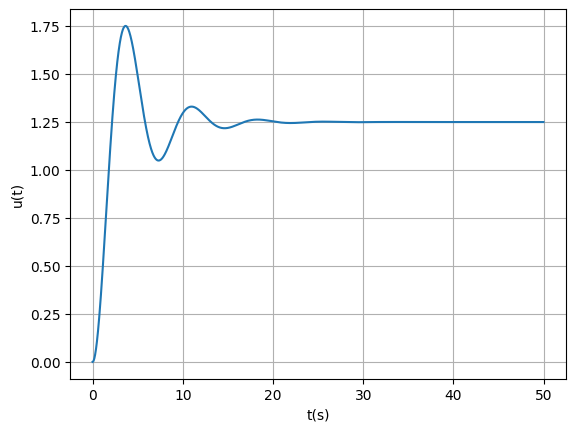

In [20]:
plt.plot(t,y)
plt.grid()
plt.xlabel('t(s)')
plt.ylabel('u(t)')
plt.show()

# Identificação de Sistemas:

In [21]:
# Geração do sinal PRBS:
u = 2*(sg.max_len_seq(8)[0]-0.5)
Ns = 5                  # Número de vezes que cada amostra será repetida na sequência;
v = np.ones(Ns)       
u = np.kron(u,v)        
N = len(u)
Ts = 0.2
t = Ts*np.arange(0,N)
y = np.squeeze(sg.lsim(G, u, T = t)[1])

In [35]:
# Dados de saída:
y_test = sg.lsim(G, u, T = t)[1]


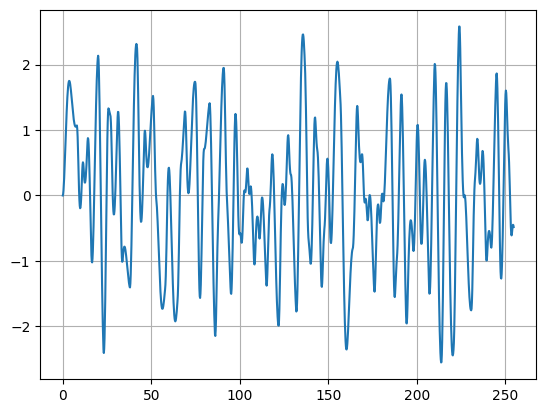

In [36]:
plt.plot(t,y_test)
plt.grid()
plt.show()

In [37]:
# Dados de saída:
y = np.squeeze(sg.lsim(G, u, T = t)[1])

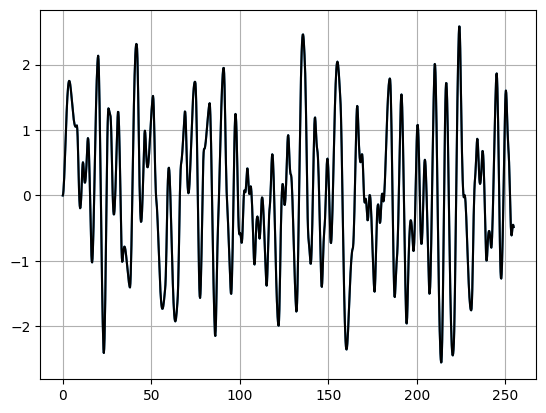

In [50]:
plt.plot(t,y)
plt.plot(t,y, "k")
plt.grid()
plt.show()

In [39]:
percIdent = 0.6         # Percentual dos dados de identificação:
Ni = int(percIdent*N)   # Quantidade de amostras para identificação:
Ni

765

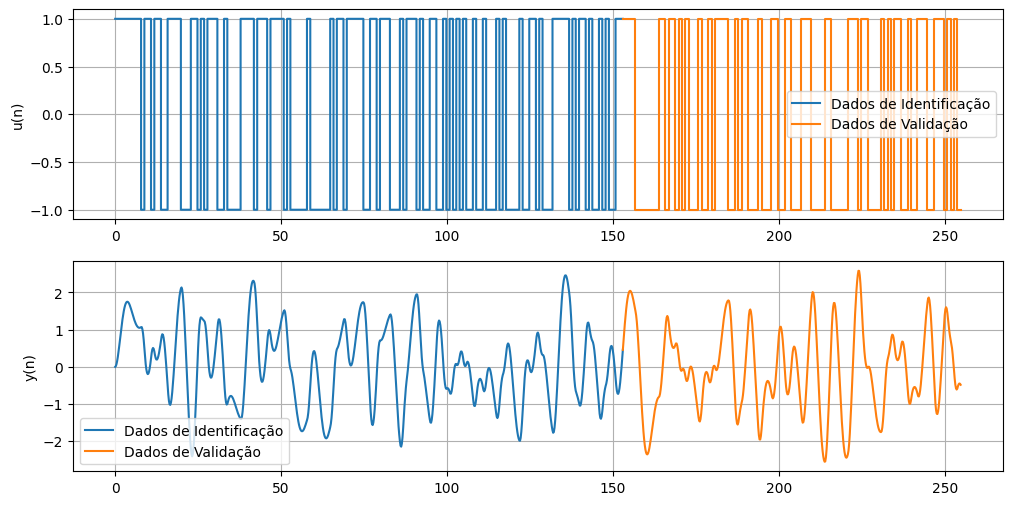

In [40]:
plt.figure(figsize = (12,6))
plt.subplot(211)
plt.step(t[:Ni+1],u[:Ni+1],label='Dados de Identificação')
plt.step(t[Ni:],u[Ni:],label='Dados de Validação')
plt.ylabel('u(n)')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(t[:Ni+1],y[:Ni+1], label='Dados de Identificação')
plt.plot(t[Ni:],y[Ni:],label='Dados de Validação')
plt.legend()
plt.grid()
plt.ylabel('y(n)')
plt.show()

In [41]:
# Matriz de regressão:
nb = 3
na = 2
ni = np.arange(na, Ni + na)
M = np.zeros((Ni, na + nb))

# Para regressores de y:
for l in np.arange(0, na):
  M[:, l] = y[ni - l - 1]

# Para regressores de u:
for l in np.arange(0, nb):
  M[:,na+l] = u[ni-l]

# Mínimos quadrados
thetaA = np.linalg.inv(M.T@M)@M.T@y[ni]
thetaA

array([ 1.8744665 , -0.90483742,  0.00649297,  0.02529453,  0.00617615])

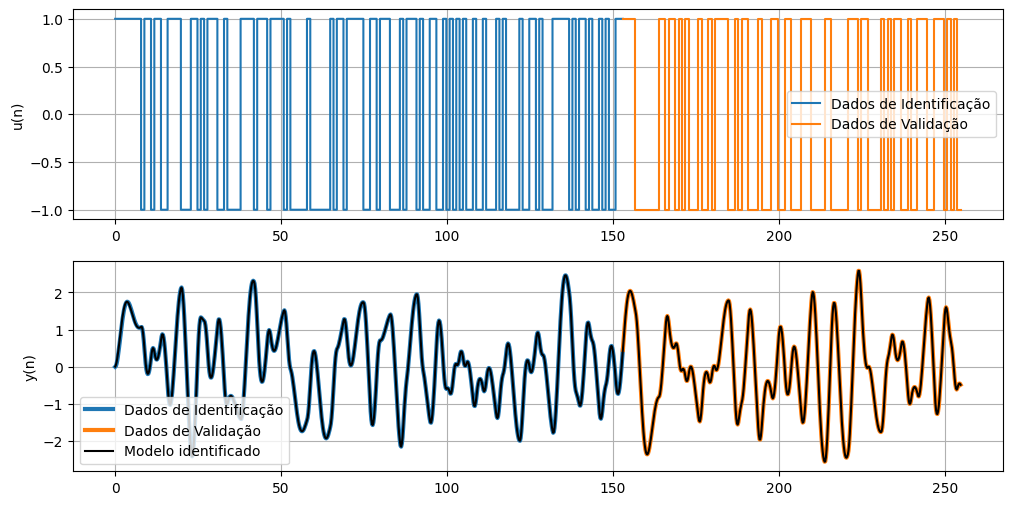

TransferFunctionDiscrete(
array([0.00649297, 0.02529453, 0.00617615]),
array([ 1.        , -1.8744665 ,  0.90483742]),
dt: 0.2
)


In [42]:
a1 = thetaA[0]
a2 = thetaA[1]
b0 = thetaA[2]
b1 = thetaA[3]
b2 = thetaA[4]
Ba = [b0 , b1, b2]
Aa = [1, -a1, -a2]

Gi = sg.TransferFunction(Ba,Aa, dt = Ts)

# Resposta do modelo identificado:
yp = np.squeeze(sg.dlsim(Gi, u, t = t)[1])

plt.figure(figsize = (12,6))
plt.subplot(211)
plt.step(t[:Ni+1],u[:Ni+1],label='Dados de Identificação')
plt.step(t[Ni:],u[Ni:],label='Dados de Validação')
plt.ylabel('u(n)')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(t[:Ni+1],y[:Ni+1],linewidth = 3.0,label='Dados de Identificação')
plt.plot(t[Ni:],y[Ni:],linewidth = 3.0,label='Dados de Validação')
plt.plot(t,yp,'k',label='Modelo identificado')
plt.legend()
plt.grid()
plt.ylabel('y(n)')
plt.show()

print(Gi)

Métrica NRMSE

$$ NRMSE = \Big(1 - \frac{\sum(y - y_p)^2}{\sum(y - \mu_y)^2} \Big)\cdot 100\%$$

In [43]:
# Avaliação por NRMSE:
NRMSE = (1- np.sqrt(np.sum((y[Ni:] - yp[Ni:])**2))/np.sqrt(np.sum((y[Ni:] - np.mean(y[Ni:]))**2)))*100
print('Ajuste: ', NRMSE.round(2),"%")

Ajuste:  100.0 %


In [44]:
def calculate_nrmse(y_pred, y_true):
    n = len(y_true)
    numerator = np.sum((y_pred - y_true)**2)
    denominator = (np.max(y_true) - np.min(y_true))**2
    nrmse = np.sqrt(numerator/n) / np.sqrt(denominator)
    return nrmse

nrmse = calculate_nrmse(yp[Ni:], y[Ni:])
print(f"\nNRMSE:{nrmse*100:.2f}%\n")


NRMSE:0.00%



## Solução por otimização:

$$J_2(\zeta) = ||A\zeta - y||_2$$

In [45]:
def J2(theta0,t):
    M,yi=t
    return np.sum(np.abs(M@theta0-yi))

In [47]:
yi = y[ni]
dados = (M,yi)
theta0 = np.array([1,1,1,1,1]).reshape(5,1)
thetaO = scipy.optimize.fmin(J2,theta0,args=(dados,));

Optimization terminated successfully.
         Current function value: 0.000270
         Iterations: 309
         Function evaluations: 504


In [48]:
print('xia: ', thetaA)
print('xio: ', thetaO)

xia:  [ 1.8744665  -0.90483742  0.00649297  0.02529453  0.00617615]
xio:  [ 1.87446567 -0.90483691  0.00649324  0.02529457  0.0061762 ]
